<h1><center>Sensors and Sunlight: How We Can Identify Plant Species From Space</center></h1>

## Background

### How is identifying plants without seeing them even possible?

The type of light that we as humans can see is called visible light, and this light is what brings color to our world. It's what makes the ocean look blue or the grass green. Everything on Earth absorbs and reflects light, including plants, but the amount that is absorbed and reflected varies from object to object. Plants, for example, are green because the majority of the light they reflect is green light. They reflect lights in other colors as well, but they mostly absorb them. However, all plants are different. Let's say the light that plant A is reflecting is 95% green light and 5% blue light, whereas plant B is reflecting 85% green light and 15% blue light. Specialized field equipment can be used to determine what type of light a plant is reflecting and how much of it. Similarly, these measurements can be made on a larger scale by flying sensors that also measure how much of each light type is reflected over the Earth's surface, and we can make determinations of what plant species are where by combining these data. This is the end-goal of the project on which I'm working using data obtained by the National Ecological Observatory Network (NEON), and my part is to create a reproducible analysis to start working toward that goal.

### Where is NEON data collected?

NEON data is collected at 81 sites located throughout the United States (shown in the first image below), but my analysis is being created with the sites in the western United States in mind (shown in the second image below). However, the analysis can be used for any NEON site where plants grow.

In [1]:
# Import required packages

import os

import geopandas as gpd
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
from shapely.geometry import box
import numpy as np
import earthpy.plot as ep
import h5py

# Set working directory
directory_path = os.path.join(et.io.HOME, "earth-analytics", "data")

# Create directory
os.chdir(directory_path)

In [2]:
# Set metadata url
et.data.get_data(url="https://raw.githubusercontent.com/rami8797/macrosystems_spectral_variance/main/data/NEON_Field_Site_Metadata_20220224.csv")

# Create path to NEON metadata
metadata_path = os.path.join("earthpy-downloads",
                             "NEON_Field_Site_Metadata_20220224.csv")

# Read in metadata
metadata_df = pd.read_csv(metadata_path)
# Download map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Restrict map to usa.
usa = world[world.name == "United States of America"]

In [3]:
# Convert pandas dataframe to a geopandas dataframe
metadata_gdf = gpd.GeoDataFrame(metadata_df,
                    geometry=gpd.points_from_xy(metadata_df.field_longitude,
                                                metadata_df.field_latitude))

# Assign crs to metadata_gpd
metadata_assigned_crs = metadata_gdf.set_crs(epsg=4326)

# Create a box for the western United States
west_box = box(-130, 25, -100, 50)

C:\Users\Rachel\miniconda3\envs\earth-analytics-python\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


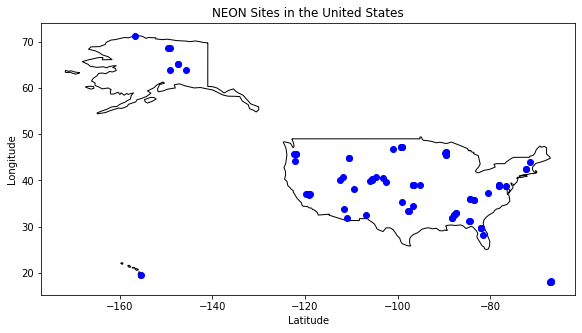

In [6]:
# Plot filtered data
# Define figure space
fig, ax = plt.subplots(figsize=(25, 5))

# Plot map of usa
usa.plot(ax=ax, color="none", edgecolor="black")

# Add plot locations
metadata_gdf.plot(ax=ax, 
                column="field_site_id",
                 color="blue")

# Set title
ax.set(xlabel="Latitude", 
       ylabel="Longitude",
      title="NEON Sites in the United States")

plt.show()

*Locations of NEON field sites.*

C:\Users\Rachel\miniconda3\envs\earth-analytics-python\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


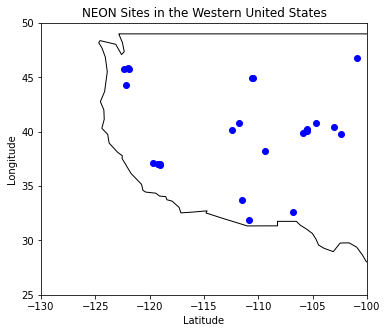

In [7]:
# Plot filtered data
# Define figure space
fig, ax = plt.subplots(figsize=(25, 5))

# Plot map of usa
usa.plot(ax=ax, color="none", edgecolor="black")

# Add plot locations
metadata_gdf.plot(ax=ax, 
                column="field_site_id",
                 color="blue")
# Set title
ax.set(xlabel="Latitude", 
       ylabel="Longitude", 
       title="NEON Sites in the Western United States")

# Use west_box.bounds to resrict plot to west
plt.xlim(west_box.bounds[0], west_box.bounds[2])
plt.ylim(west_box.bounds[1], west_box.bounds[3])

plt.show()

*Extent of the project study area and the NEON sites within it.*

## Data Application

### How exactly will your analysis help identify plants?

The reproducible analysis that I am working on for my project will allow users to select NEON sites of interest by filtering NEON sites by site characteristics and location. The extent of the project area is the western United States; however any four coordinates can be used to form a polygon that will return the NEON sites located within it. Further, users can filter by site characteristics such as if non-neon research is allowed, average number of green days per year, soil type, field site type (e.g. terrestrial or aquatic), along with other characteristics. Once sites of interest are known, the analysis will also report the dates when reflectance data was collected and is available for the filtered sites, request the reflectance data, process the reflectance data, and plot the reflectance data. Plotting the data and being able to visualize it will allow researchers to make decisions regarding when sampling should take place.

### What does reflectance data look like?

Light occurs at different wavelengths. It's measured in nanometers (nm), and humans can see some of it, but not all of it. It's that visible light that brings color to our worlds, and it exits at the wavelengths that occur at or between 380 and 700 nm. The first image below is a representation of the wavelengths we can and cannot see. There are 426 data points, and each point represents a small range (5 nm) of wavelengths and the average amount of light being reflected at each point. The boxes are the wavelength ranges that are captured by a drone-mounted-sensor that will be used for data collection. It's a sensor that only picks up certain wavelengths as opposed to the aerial platform sensor that collected all of the wavelengths in the figure. This project aims to create a workflow that analyzes the wavelengths within the boxes. The second image is the data that was collected by the aerial platform sensor at wavelength 566.9639, which is within the range of wavelengths where green light occurs. This is the green light that is being reflected.

In [6]:
# Download the data
et.data.get_data(url="https://storage.googleapis.com/neon-aop-products/2020/FullSite/D13/2020_NIWO_4/L3/Spectrometer/Reflectance/NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5")

# Create path to hdf5 file
h5_path = os.path.join("earthpy-downloads", "NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5")

In [7]:
def clean_h5_refl(file_path):
    """Reads in a NEON AOP reflectance h5 file and returns cleaned reflectance data (scale factor and no data value applied) and metadata.

    --------
    Parameters
    file_path: string
        Full or relative path and name of reflectance h5 file
    --------
    Returns 
    --------
    refl_array:
        Array of reflectance data
    metadata:
        dictionary containing the following metadata:
            epsg: coordinate system code (float)
            spatial extent: spatial extent information
            wavelength: wavelength values (float)
            sitename: Location sitename
    map_info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
    """
    
    # Read in file
    h5 = h5py.File(file_path, "r")
    
    # Get the site name
    file_attrs_string = str(list(h5.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]

    # Access the reflectance "folder"
    site_refl = h5[sitename]["Reflectance"]
    
    # Assign reflectance array to a variable
    site_refl_data = site_refl["Reflectance_Data"]

    # Assgign reflectance values to a variable
    refl_raw = site_refl["Reflectance_Data"][()]
    
    # Create dictionary containing relevant metadata information
    metadata = {}
    metadata["wavelength"] = site_refl["Metadata"]["Spectral_Data"]["Wavelength"]
    
    # Define the wavelengths variable
    wavelengths = site_refl["Metadata"]["Spectral_Data"]["Wavelength"]
    
    # Extract no data value & scale factor
    scale_factor = site_refl_data.attrs["Scale_Factor"]
    no_data_value = site_refl_data.attrs["Data_Ignore_Value"]
    
    # Apply no data value
    refl_clean = refl_raw.astype(float)
    arr_size = refl_clean.shape
    if no_data_value in refl_raw:
        print("% No Data: ",np.round(np.count_nonzero(refl_clean==metadata["data ignore value"])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(refl_clean==no_data_value)
        refl_clean[nodata_ind]=np.nan
    
    # Apply scale factor
    refl_array = refl_clean/scale_factor
    
    # Extract spatial extent from attributes
    metadata["spatial extent"] = site_refl_data.attrs["Spatial_Extent_meters"]
    
    # Extract projection information
    metadata["projection"] = site_refl["Metadata"]["Coordinate_System"]["Proj4"][()]
    metadata["epsg"] = int(site_refl["Metadata"]["Coordinate_System"]["EPSG Code"][()])
    
    # Extract map information: spatial extent & resolution (pixel size)
    map_info = (site_refl["Metadata"]["Coordinate_System"]["Map_Info"][()])
    
    # Put sitename into metadata
    metadata["sitename"] = sitename
    
    h5.close
    
    return refl_array, metadata, map_info

In [8]:
refl_data, metadata, map_info = clean_h5_refl(h5_path)

In [9]:
# Loop through reflectance array to calculate mean reflectance for each band
# Create empty list
reflectance = []
for band in np.arange(refl_data.shape[2]):
        refl_band = refl_data[:,:,band]
        refl_mean = refl_band.mean()
        reflectance.append(refl_mean)

In [10]:
# Assign wavelength data to a variable
wavelengths = metadata["wavelength"]

In [11]:
# Create pandas dataframe for plotting
refl_df = pd.DataFrame()
refl_df["wavelength"] = wavelengths
refl_df["reflectance"] = reflectance

In [12]:
# Make boxes to overlay on waveform image that represent bands picked up by MicaSense
# Create boxes with box(minx, miny, maxx, maxy)
box_1 = box(444, 0.005, 472, 0.035)
box_2 = box(475, 0.005, 507, 0.035)
box_3 = box(531, 0.02, 545, 0.05)
box_4 = box(560, 0.02, 587, 0.05)
box_5 = box(650, 0.01, 666, 0.04)
box_6 = box(668, 0.01, 682, 0.04)
box_7 = box(705, 0.04, 715, 0.09)
box_8 = box(717, 0.05, 729, 0.1)
box_9 = box(740, 0.115, 758, 0.135)
box_10 = box(842, 0.135, 899, 0.165)

# Create list of boxes
box_list = [box_1, box_2, box_3, box_4, box_5, box_6, box_7, box_8, box_9, box_10]

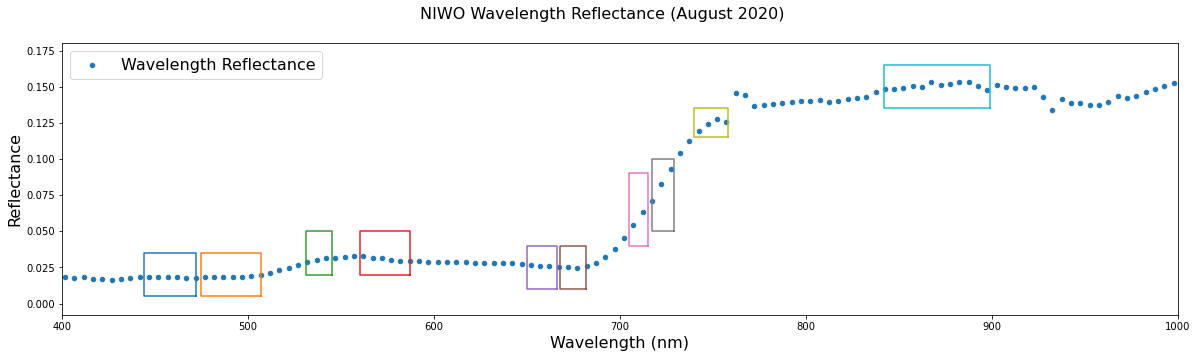

In [13]:
# Define figure space
fig, ax = plt.subplots(figsize=(20, 5))

# Plot wavelength
refl_df.plot(ax=ax, 
             x="wavelength",
             y="reflectance",
             kind="scatter", 
             label="Wavelength Reflectance",
             legend=True)

# Set title
fig.suptitle("NIWO Wavelength Reflectance (August 2020)", fontsize=16)

# Set x and y axis labels
plt.xlabel("Wavelength (nm)", fontsize=16)
plt.ylabel("Reflectance", fontsize=16)

# Add legend
ax.legend(prop={'size': 16})

# Restrict x-axis limits
ax.set_xlim([400, 1000])

# Add boxes using for loop
for box in box_list:
    plt.plot(*box.exterior.xy)

*All wavelengths represented in a single reflectance file. Boxes represent groups of bands that the project aims to analyze.*

In [14]:
# Find band that falls within the green band range
print('band 38 center wavelength (nm): ',metadata['wavelength'][37])

band 38 center wavelength (nm):  566.9639


In [15]:
# Extract green band
green_band = refl_data[:,:,37]

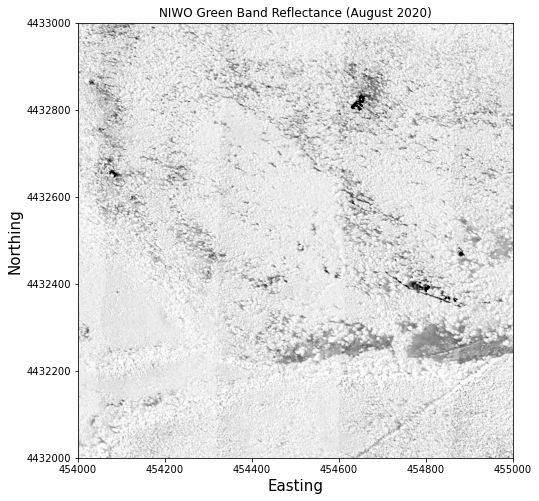

In [16]:
# Define figure space
fig, ax = plt.subplots(figsize=(8, 8))

# Plot green band
plt.imshow(green_band,
           extent=metadata["spatial extent"],
           vmax=0.15,
          cmap="Greys")

# Set axis labels and plot title
ax.set(title="NIWO Green Band Reflectance (August 2020)")
ax.set_xlabel("Easting", fontsize = 15)
ax.set_ylabel("Northing", fontsize =15)

# Turn off axis labels being in scientific notation
ax.ticklabel_format(style="plain")

*Green reflectance band visualization.*

## Current Findings and Future Work

### So what did you find?

We were able to plot the distribution on reflectance data for one area of one site in one point in time. Achieving this means that this can be reproduced for other areas, other sites, and other points in time. By looking at the data, we can see the amount of it that was not captured during sampling.

![Data Distribution](/images/reflectance_distribution.png)

### How did you do this?

Individual parts will allow users to do the following:

1. Select NEON sites of interest by filtering sites by site characteristics and location.
2. Report the dates when data was collected and is available for the filtered sites. 
3. Request the data.
4. Prepare the data for plotting.
5. Plot the data.

Currently, I have combined steps 1-3 so that all sites that make it past filtering are reported along with the dates that have available data; and along with each date, a list of data files is reported, each one containing data that can be analyzed by the reproducible analysis. 

### Why does it matter?

This workflow is simplifying the analysis by combining multiple steps that, if done individually, would be time-consuming and inefficient. This reproducible analysis is also the project's preliminary work, so it is laying the groundwork for future steps taken toward the project's end-goal.

### What's next?

I will finish combining the parts of the analysis that will prepare the data for plotting and plot the data. Beyond the creation of this analysis, future work will involve analyzing the plotted data between different spatial and temporal points to determine when and where sampling should be conducted to capture as much data as possible.

## Resources

### Additional Information

Visit https://github.com/rami8797/macrosystems_spectral_variance for more information regarding this project.

### Citations

Data used to produce figures was made available by the National Ecological Observatory Network (NEON).